In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dask_ml.preprocessing import Categorizer
from glum import GeneralizedLinearRegressor, TweedieDistribution
from lightgbm import LGBMRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, SplineTransformer, StandardScaler
#import everything here in the masterfile
#kernels sometimes need to be restarted when new lib installed
import dalex as dx
import nbformat

import sys
from pathlib import Path

# Getting project root
project_root = Path.cwd().resolve().parent

# Add the project root directory to sys.path
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))


from ps3.data import create_sample_split, load_transform
from evaluation.evaluate_predictions import evaluate_predictions
#from ps3.data import train_tweedie, model_pipeline, spline_model
#only if code reworked modularly, currently not needed

In [6]:
# load data
df = load_transform()
df.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountCut
0,1,0,0.10,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
1,3,0,0.77,D,5,0,5,50,B12,Regular,1217,R82,0.0,0.0
2,5,0,0.75,B,6,1,5,50,B12,Diesel,54,R22,0.0,0.0
3,10,0,0.09,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0
4,11,0,0.84,B,7,0,4,50,B12,Diesel,76,R72,0.0,0.0


In [7]:
# Checking to ensure IDpol column is unique - we shall carry out split on this
len(df["IDpol"].unique()) == len(df)

True

In [8]:
# Train benchmark tweedie model. This is entirely based on the glum tutorial.
#weight = df["Exposure"].values
df["PurePremium"] = df["ClaimAmountCut"] / df["Exposure"]

outcome = "PurePremium"
# TODO: Why do you think, we divide by exposure here to arrive at our outcome variable?
'''
To get a yearly figure so we can compare claims that have a different time under risk
'''


# TODO: use your create_sample_split function here
df_split = create_sample_split(df,"IDpol",0.8)
df_train = df_split[0].copy()
df_test = df_split[1].copy()


categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]

predictors = categoricals + ["BonusMalus", "Density"]
glm_categorizer = Categorizer(columns=categoricals)


X_train_t = glm_categorizer.fit_transform(df_train[predictors])
X_test_t = glm_categorizer.transform(df_test[predictors])
y_train_t, y_test_t = df_train[outcome], df_test[outcome]
w_train_t, w_test_t = df_train["Exposure"], df_test["Exposure"]

TweedieDist = TweedieDistribution(1.5)
t_glm1 = GeneralizedLinearRegressor(family=TweedieDist, l1_ratio=1, fit_intercept=True)
t_glm1.fit(X_train_t, y_train_t, sample_weight=w_train_t)


pd.DataFrame(
    {"coefficient": np.concatenate(([t_glm1.intercept_], t_glm1.coef_))},
    index=["intercept"] + t_glm1.feature_names_,
).T

df_test.loc[:,"pp_t_glm1"] = t_glm1.predict(X_test_t)
df_train.loc[:,"pp_t_glm1"] = t_glm1.predict(X_train_t)

print(
    "training loss t_glm1:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm1"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm1:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm1"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "Total claim amount on train set, observed = {}, predicted = {}".format(
        df_train["ClaimAmountCut"].values.sum(),
        np.sum(df_test["Exposure"].values * t_glm1.predict(X_test_t)),
    )
)

training loss t_glm1:  73.69714563112665
testing loss t_glm1:  73.69714563112665
Total claim amount on train set, observed = 39477864.25, predicted = 10031127.33604094


In [9]:
# TODO: Let's add splines for BonusMalus and Density and use a Pipeline.
# Steps: 
# 1. Define a Pipeline which chains a StandardScaler and SplineTransformer. 
#    Choose knots="quantile" for the SplineTransformer and make sure, we 
#    are only including one intercept in the final GLM. 
# 2. Put the transforms together into a ColumnTransformer. Here we use OneHotEncoder for the categoricals.
# 3. Chain the transforms together with the GLM in a Pipeline.
categoricals = ["VehBrand", "VehGas", "Region", "Area", "DrivAge", "VehAge", "VehPower"]
# Let's put together a pipeline
numeric_cols = ["BonusMalus", "Density"]
preprocessor = ColumnTransformer(
    transformers=[
        # TODO: Add numeric transforms here
        ("cat", OneHotEncoder(sparse_output=False, drop="first"), categoricals),
        ("spline", SplineTransformer(knots="quantile"), numeric_cols),
        ("scale", StandardScaler(), numeric_cols)
    ]
)
preprocessor.set_output(transform="pandas")
model_pipeline = Pipeline(
    # TODO: Define pipeline steps here
    [
        ("preprocessing", preprocessor),
        (
            "estimate",
            GeneralizedLinearRegressor(
                family=TweedieDist, l1_ratio=1, fit_intercept=True
            ),
        ),
    ]
)

#incorporate this part later
# let's have a look at the pipeline
model_pipeline

# let's check that the transforms worked
model_pipeline[:-1].fit_transform(df_train)

model_pipeline.fit(df_train, y_train_t, estimate__sample_weight=w_train_t)

pd.DataFrame(
    {
        "coefficient": np.concatenate(
            ([model_pipeline[-1].intercept_], model_pipeline[-1].coef_)
        )
    },
    index=["intercept"] + model_pipeline[-1].feature_names_,
).T

df_test.loc[:,"pp_t_glm2"] = model_pipeline.predict(df_test)
df_train.loc[:,"pp_t_glm2"] = model_pipeline.predict(df_train)

print(
    "training loss t_glm2:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_glm2"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_glm2:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_glm2"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)
# Create Boolean mask for test rows 
test = df["sample"] == "test"
print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_glm2"]),
    )
)


training loss t_glm2:  73.39339556486237
testing loss t_glm2:  73.51750641020485
Total claim amount on test set, observed = 9824331.800000003, predicted = 9993494.993666084


In [10]:
model_pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['VehBrand', 'VehGas',
                                                   'Region', 'Area', 'DrivAge',
                                                   'VehAge', 'VehPower']),
                                                 ('spline',
                                                  SplineTransformer(knots='quantile'),
                                                  ['BonusMalus', 'Density']),
                                                 ('scale', StandardScaler(),
                                                  ['BonusMalus', 'Density'])])),
                ('estimate',
                 GeneralizedLinearRegressor(family=<glum._distribution.TweedieDistribution object at 0x2826f2de0>,
                                            l1_ratio=1))])

In [11]:
# TODO: Let's use a GBM instead as an estimator.
# Steps
# 1: Define the modelling pipeline. Tip: This can simply be a LGBMRegressor based on X_train_t from before.
# 2. Make sure we are choosing the correct objective for our estimator.
model_pipeline = Pipeline([("estimate", LGBMRegressor(objective="tweedie"))])
model_pipeline.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)
df_test.loc[:,"pp_t_lgbm"] = model_pipeline.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm"] = model_pipeline.predict(X_train_t)
print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)
#substantial difference between losses, might overfit for training

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267
training loss t_lgbm:  65.11231328262183
testing loss t_lgbm:  73.2935475875686


In [12]:
# TODO: Let's tune the LGBM to reduce overfitting.
# Steps:
# 1. Define a `GridSearchCV` object with our lgbm pipeline/estimator. Tip: Parameters for a specific step of the pipeline
# can be passed by <step_name>__param. 

# Note: Typically we tune many more parameters and larger grids,
# but to save compute time here, we focus on getting the learning rate
# and the number of estimators somewhat aligned -> tune learning_rate and n_estimators
cv_u_lgbm = GridSearchCV(
    model_pipeline,
    {
        "estimate__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "estimate__n_estimators": [50, 100, 150, 200],
    },
    verbose=2,
)
cv_u_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)

df_test.loc[:,"pp_t_lgbm"] = cv_u_lgbm.best_estimator_.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm"] = cv_u_lgbm.best_estimator_.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm"]),
    )
)
#[CV] END estimate__learning_rate=0.1, estimate__n_estimators=200; total time=   2.1s

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.897331
[CV] END estimate__learning_rate=0.01, estimate__n_estimators=50; total time=   1.0s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.913501
[CV] END estimate__learning_rate=0.01, esti

In [13]:
# Saving best unconstrained lgbm model

best_unconstrained_lgbm = cv_u_lgbm.best_estimator_


[]

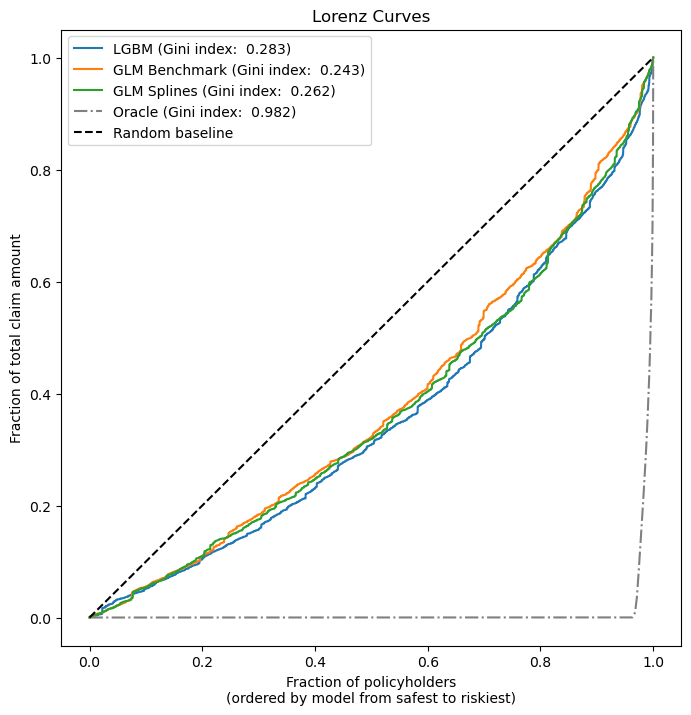

In [14]:
# Let's compare the sorting of the pure premium predictions
# Source: https://scikit-learn.org/stable/auto_examples/linear_model/plot_tweedie_regression_insurance_claims.html
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # order samples by increasing predicted risk:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

for label, y_pred in [
    ("LGBM", df_test["pp_t_lgbm"]),
    ("GLM Benchmark", df_test["pp_t_glm1"]),
    ("GLM Splines", df_test["pp_t_glm2"]),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += f" (Gini index: {gini: .3f})"
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = f"Oracle (Gini index: {gini: .3f})"
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()

/var/folders/sj/rpr9y2fx5c99hjkqtppxm2zm0000gn/T/ipykernel_26573/1327824370.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated = df.groupby("BonusMalusBin").apply(
/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/sj/rpr9y2fx5c99hjkqtppxm2zm0000gn/T/ipykernel_26573/1327824370.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either

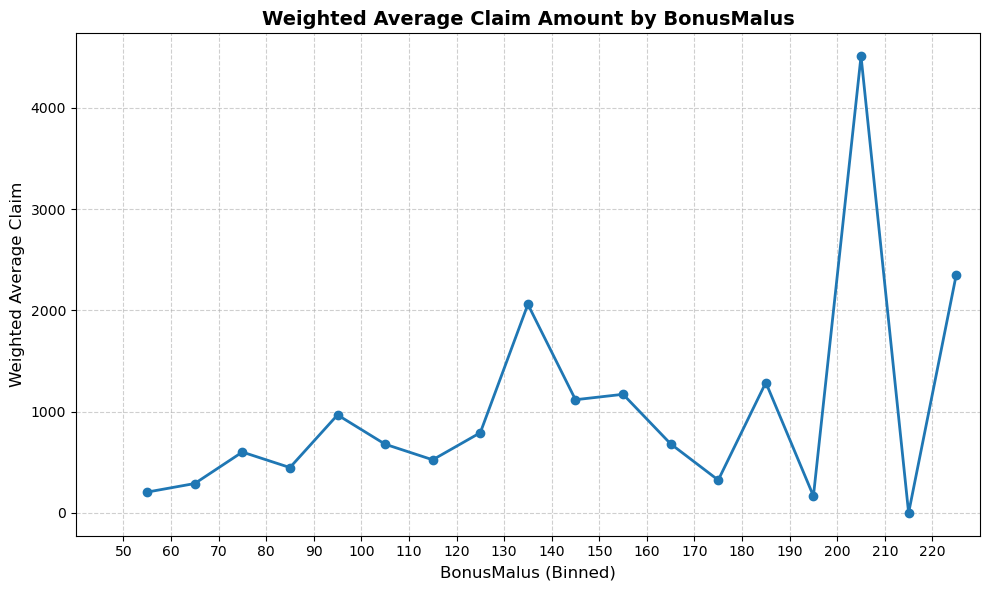

In [15]:
#START OF PROBLEM SET 4
#EX1 MONOTONOCITY CONSTRAINTS
#EX1.1 Plotting average claims
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
bin_edges = list(range(50, 260, 10))
df['BonusMalusBin'] = pd.cut(df['BonusMalus'], bins=bin_edges, include_lowest=True) #need to specify true, otherwise 50 exluded as first interval open
aggregated = df.groupby("BonusMalusBin").apply(
    lambda x: np.average(x["PurePremium"])
).reset_index(name='WeightedAvgClaim')

aggregated['BinMidpoint'] = aggregated['BonusMalusBin'].apply(lambda b: (b.left + b.right) / 2)

plt.figure(figsize=(10, 6))
plt.plot(aggregated['BinMidpoint'], aggregated['WeightedAvgClaim'], marker='o', linestyle='-', linewidth=2)
#custom xaxis for interpretability
plt.xlim(40, 230)  
plt.xticks(range(50, 230, 10))
plt.xticks(fontsize=10)

#generating titles
plt.title('Weighted Average Claim Amount by BonusMalus', fontsize=14, weight='bold')
plt.xlabel('BonusMalus (Binned)', fontsize=12)
plt.ylabel('Weighted Average Claim', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

#What will/could happen if we do not include a monotonicity constraint?
#here breaks are observed and claim amount is generally linearly increasing, but there are notable breaks
#130-140 is the first peak and as we move to groups with less and less representation the average claim becomes more volatile
#last 7 bins dont include much more than 50 people total and last 3 bins include 4 people overall
#except for peak at 130/140 results for well represented values as expected

In [16]:
#providing numbers of people in each bin
binned_data = pd.cut(df["BonusMalus"], bins=bin_edges, include_lowest=True)
bin_counts = binned_data.value_counts().sort_index()
print(bin_counts)

BonusMalus
(49.999, 60.0]    478602
(60.0, 70.0]       56929
(70.0, 80.0]       61826
(80.0, 90.0]       35725
(90.0, 100.0]      37137
(100.0, 110.0]      1989
(110.0, 120.0]      3565
(120.0, 130.0]      1458
(130.0, 140.0]       374
(140.0, 150.0]       199
(150.0, 160.0]       144
(160.0, 170.0]        16
(170.0, 180.0]        17
(180.0, 190.0]        17
(190.0, 200.0]        11
(200.0, 210.0]         1
(210.0, 220.0]         1
(220.0, 230.0]         2
(230.0, 240.0]         0
(240.0, 250.0]         0
Name: count, dtype: int64


In [17]:
#creating placeholder array for monotonic constraints 
num_features = X_train_t.shape[1]
monotonic_constraints = [0] * num_features
monotonic_constraints[7] = 1 #(9 predictors in total and listed from 0 so bonus malus index 7)

numeric_cols = ["BonusMalus", "Density"]

constrained_lgbm = Pipeline(
    [
        ("preprocessing", preprocessor),
        (
            "estimate",
            GeneralizedLinearRegressor(
                family=TweedieDist, l1_ratio=1, fit_intercept=True
            ),
        ),
    ]
)
#renamed pipeline
constrained_lgbm = Pipeline([("estimate", LGBMRegressor(objective="tweedie", monotone_constraints=monotonic_constraints))])
constrained_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)
df_test.loc[:,"pp_t_lgbm"] = constrained_lgbm.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm"] = constrained_lgbm.predict(X_train_t)
print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)
#different results than the regular lgbm, which is encouraging
#greater loss for both expected, as we have introduced further constraints on our model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267
training loss t_lgbm:  65.85198945351796
testing loss t_lgbm:  73.90055621262542


In [18]:


#tuning our constrained lgbm given different learning rates, different number of estimators and 
cv_c_lgbm = GridSearchCV(
    constrained_lgbm,
    {
        "estimate__learning_rate": [0.01, 0.02, 0.03, 0.04, 0.05, 0.1],
        "estimate__n_estimators": [50, 100, 150, 200],
    }
)
cv_c_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=w_train_t)

df_test.loc[:,"pp_t_lgbm_constrained"] = cv_c_lgbm.best_estimator_.predict(X_test_t)
df_train.loc[:,"pp_t_lgbm_constrained"] = cv_c_lgbm.best_estimator_.predict(X_train_t)

print(
    "training loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_train_t, df_train["pp_t_lgbm_constrained"], sample_weight=w_train_t)
        / np.sum(w_train_t)
    )
)

print(
    "testing loss t_lgbm:  {}".format(
        TweedieDist.deviance(y_test_t, df_test["pp_t_lgbm_constrained"], sample_weight=w_test_t)
        / np.sum(w_test_t)
    )
)

print(
    "Total claim amount on test set, observed = {}, predicted = {}".format(
        df["ClaimAmountCut"].values[test].sum(),
        np.sum(df["Exposure"].values[test] * df_test["pp_t_lgbm_constrained"]),
    )
)
#higher training loss but a lower testing loss, seems like an improvement

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 404
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.897331
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 406
[LightGBM] [Info] Number of data points in the train set: 433813, number of used features: 9
[LightGBM] [Info] Start training from score 4.913501
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005375 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,

In [19]:
# Saving best constrained lgbm model

best_constrained_lgbm = cv_c_lgbm.best_estimator_

In [20]:
#EX2 LEARNING CURVE
#EX2.1 Re-fit the best constrained lgbm estimator
import lightgbm as lgb

best_constrained_lgbm = cv_c_lgbm.best_estimator_
lgbm_model = best_constrained_lgbm.named_steps['estimate']
eval_set = [(X_train_t, y_train_t), (X_test_t, y_test_t)]

lgbm_model.fit(
    X_train_t, y_train_t, 
    sample_weight=w_train_t, 
    eval_set=eval_set,
    eval_metric='l2',
    eval_names=['train', 'test']
)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267


LGBMRegressor(learning_rate=0.04,
              monotone_constraints=[0, 0, 0, 0, 0, 0, 0, 1, 0],
              n_estimators=150, objective='tweedie')

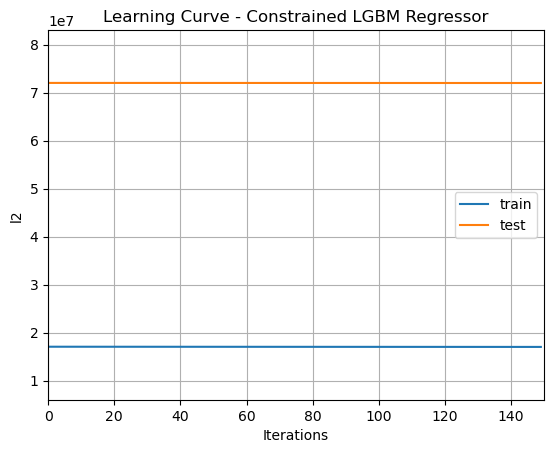

In [21]:
# Plot
lgb.plot_metric(lgbm_model, metric='l2')
plt.title('Learning Curve - Constrained LGBM Regressor')
plt.show()

The training and tesing loss values are high and the learning curves are almost horizontal, this may suggest underfitting. The constrained model hasn't learned the relationship in the data well.

In [22]:
#EX3: Metrics function


def compare_models(X_train_t, y_train_t, X_test_t, y_test_t, sample_weight, monotonic_constraints=None):
    # Models
    constrained_lgbm = Pipeline([
        ("estimate", lgb.LGBMRegressor(objective="tweedie", monotone_constraints=monotonic_constraints))
    ])
    unconstrained_lgbm = Pipeline([("estimate", lgb.LGBMRegressor(objective="tweedie"))])

    # Train models
    constrained_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=sample_weight)
    unconstrained_lgbm.fit(X_train_t, y_train_t, estimate__sample_weight=sample_weight)

    # Predictions
    y_pred_constrained = constrained_lgbm.predict(X_test_t)
    y_pred_unconstrained = unconstrained_lgbm.predict(X_test_t)

    # Evaluate predictions
    evaluation_constrained = evaluate_predictions(y_test_t, y_pred_constrained, sample_weight=sample_weight)
    evaluation_unconstrained = evaluate_predictions(y_test_t, y_pred_unconstrained, sample_weight=sample_weight)

    return {
        "Constrained Model Evaluation": evaluation_constrained,
        "Unconstrained Model Evaluation": evaluation_unconstrained
    }

# Results
results = compare_models(X_train_t, y_train_t, X_test_t, y_test_t, w_train_t, monotonic_constraints=monotonic_constraints)

print("Constrained Model Evaluation:")
print(results["Constrained Model Evaluation"])

print("\nUnconstrained Model Evaluation:")
print(results["Unconstrained Model Evaluation"])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 409
[LightGBM] [Info] Number of data points in the train set: 542267, number of used features: 9
[LightGBM] [Info] Start training from score 4.925267
Constrained Model Evaluation:
                 Value
Metric                
Bias     -1.245430e+02
Deviance  9.772517e+12
MAE       3.739345e+02
RMSE      8.484763e+03
Gini      2.070645e-01

In [23]:
y_test_t

16        0.0
25        0.0
33        0.0
37        0.0
42        0.0
         ... 
677984    0.0
678002    0.0
678003    0.0
678006    0.0
678008    0.0
Name: PurePremium, Length: 135746, dtype: float64

In [60]:
# Creating explainer for unconstrained LGBM
best_unconstrained_lgbm_exp = dx.Explainer(best_unconstrained_lgbm, X_train_t, y_train_t, label="Unconstrained LGBM")

# Creating explainer for constrained LGBM
best_constrained_lgbm_exp = dx.Explainer(best_constrained_lgbm, X_train_t, y_train_t, label="Constrained LGBM")

Preparation of a new explainer is initiated

  -> data              : 542267 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 542267 values
  -> model_class       : lightgbm.sklearn.LGBMRegressor (default)
  -> label             : Unconstrained LGBM
  -> predict function  : <function yhat_default at 0x281116e80> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 5.75, mean = 1.3e+02, max = 7.41e+03
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -5.94e+03, mean = 1.93e+02, max = 1e+07
  -> model_info        : package sklearn

A new explainer has been created!
Preparation of a new explainer is initiated

  -> data              : 542267 rows 9 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted 

In [25]:
X_train_t.info()

<class 'pandas.core.frame.DataFrame'>
Index: 542267 entries, 0 to 678012
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   VehBrand    542267 non-null  category
 1   VehGas      542267 non-null  category
 2   Region      542267 non-null  category
 3   Area        542267 non-null  category
 4   DrivAge     542267 non-null  category
 5   VehAge      542267 non-null  category
 6   VehPower    542267 non-null  category
 7   BonusMalus  542267 non-null  int64   
 8   Density     542267 non-null  int64   
dtypes: category(7), int64(2)
memory usage: 32.2 MB


In [26]:
# Model profile for numerical variables

# unconstrained LGBM
pd_lgbm_unconstrained = best_unconstrained_lgbm_exp.model_profile()

# Constrained LGBM
pd_lgbm_constrained = best_constrained_lgbm_exp.model_profile()

Calculating ceteris paribus:   0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 50.   51.8  53.6 ... 226.4 228.2 230. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[:, variable] = np.tile(split_points, data.shape[0])
Calculating ceteris paribus:  89%|████████▉ | 8/9 [00:00<00:00, 74.47it/s]/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.000000e+00 2.709900e+02 5.409800e+02 ... 2.646002e+04 2.673001e+04
 2.700000e+04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_data.loc[:, variable] 

In [27]:
# Plots for unconstrained LGBM

pd_lgbm_unconstrained.plot()

In [28]:
# Plots for constrained LGBM

pd_lgbm_constrained.plot()

In [29]:
# Model profile for categorical variables

# unconstrained LGBM
pd_lgbm_unconstrained_cat = best_unconstrained_lgbm_exp.model_profile(variable_type="categorical")

# Constrained LGBM
pd_lgbm_constrained_cat = best_constrained_lgbm_exp.model_profile(variable_type="categorical")

Calculating ceteris paribus:   0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 50.   51.8  53.6 ... 226.4 228.2 230. ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/utils.py:100: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1.000000e+00 2.709900e+02 5.409800e+02 ... 2.646002e+04 2.673001e+04
 2.700000e+04]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

Calculating ceteris paribus:   0%|          | 0/9 [00:00<?, ?it/s]/opt/anaconda3/envs/ps3_2/lib/python3.12/site-packages/dalex/predict_explanations/_ceteris_paribus/

In [30]:
# Plots for unconstrained LGBM

pd_lgbm_unconstrained_cat.plot()

In [31]:
# Plots for constrained LGBM

pd_lgbm_constrained_cat.plot()

In [ ]:
# EX 5.1

best_constrained_lgbm_exp
best_unconstrained_lgbm_exp

In [67]:
# EX 5.2

X_test_t_row1 = X_test_t[0:1]

pp_best_constrained_lgbm_exp = best_constrained_lgbm_exp.predict_parts(new_observation=X_test_t_row1,
                                                                       type="shap",
                                                                       label="Contribution of each feature to the constrained prediction of the 1st observation")

pp_best_unconstrained_lgbm_exp = best_unconstrained_lgbm_exp.predict_parts(new_observation=X_test_t_row1,
                                                                           type="shap",
                                                                           label="Contribution of each feature to the unconstrained prediction of the 1st observation")


In [66]:
pp_best_constrained_lgbm_exp.plot()

In [68]:
pp_best_unconstrained_lgbm_exp.plot()

The contribution of BonusMalus to the predicted value differs across our constrained and unconstrained model which we might expect given the monotonicity constraint imposed in the constrained model which makes the contribution at this relatively low BonusMalus level negative. The direction of the contribution of region and area also varies across the two models perhaps suggesting that their overall relationship to the dependent variable is weak and thus their values adjust readily to compensate for the change in the contribution of BonusMalus.